In [0]:
import torch
import torchvision
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam

**Resizing the Dataset to 90x90 dimensions:**

In [4]:
!gdown https://drive.google.com/uc?id=1UhqNR7LxsoB9skQuiS30PTqS7NTWceJK

Downloading...
From: https://drive.google.com/uc?id=1UhqNR7LxsoB9skQuiS30PTqS7NTWceJK
To: /content/Pokemon_V3.zip
8.88MB [00:00, 140MB/s]


In [0]:
!unzip Pokemon_V3.zip

**Loading and dividing the dataset into train and test sets:**

In [0]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

data_path = '/content/content/Pokemon_V3'
dataset = torchvision.datasets.ImageFolder(
    root=data_path, transform=transform
    #transform=torchvision.transforms.ToTensor()
)
train_set, test_set = torch.utils.data.random_split(dataset, [1500, 502])

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=16,
    num_workers=0,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=16,
    num_workers=0,
    shuffle=True
)


**Convolutional Neural Network Class:**

In [0]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
class Net(torch.nn.Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(8),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(16),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear_layers = Sequential(
            Linear(32 * 5 * 5, 5)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

**Training Loop:**

In [0]:
loss_function = torch.nn.CrossEntropyLoss()
model = Net()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)

epochs = 80

train_accuracy_list = []
test_accuracy_list = []

train_loss_list = []
test_loss_list = []

test_accuracy_max = -1

for i in range(epochs):
  correct = 0
  total = 0
  total_train_loss = 0
  total_test_loss = 0

  for images, labels in train_loader:
    #images.cuda()
    images = images.to('cuda', non_blocking=True)
    
    # Training pass
    optimizer.zero_grad()
    
    output = model.forward(images)
    _, predicted = torch.max(output.data, 1) # the dimension 1 corresponds to max along the rows
    total += labels.size(0)
    correct += (predicted == labels).sum().item() 
    output.squeeze_(-1)
    loss = loss_function(output, labels)
    loss.backward()
    optimizer.step()
    total_train_loss += loss.item()
  else:
    train_loss = total_train_loss/len(train_loader)
    train_loss_list.append(train_loss)
    train_accuracy = 100 * correct / total
    train_accuracy_list.append(train_accuracy)
    correct_t = 0
    total_t = 0
    with torch.no_grad():
      for data in test_loader:
        images_t, labels_t = data
        images_t = images_t.to('cuda', non_blocking=True)
        output_t = model.forward(images_t)
        _, predicted_t = torch.max(output_t.data, 1)
        total_t += labels_t.size(0)
        correct_t += (predicted_t == labels_t).sum().item()
        output_t.squeeze_(-1)
        loss_t = loss_function(output_t,labels_t)
        total_test_loss += loss_t.item()
  
    test_loss = total_test_loss/len(test_loader)
    test_loss_list.append(test_loss)
    test_accuracy = 100 * correct_t / total_t
    test_accuracy_list.append(test_accuracy)
    print('Epoch %d:\ntrain loss: %.4f'%(i, loss.item()))
    print('test loss: %.4f'%(loss_t.item()))
    print('train_accuracy %.2f' % (train_accuracy))
    print('test_accuracy %.2f' % (test_accuracy))
    if test_accuracy > test_accuracy_max:
      test_accuracy_max = test_accuracy
      print("New Max Test Accuracy Acheived %.2f. Saving model.\n\n"%(test_accuracy_max))
      torch.save(model,'best_test_acc_model.pth')
    else:
      print("Test accuracy did not increase from %.2f\n\n"%(test_accuracy_max))


Epoch 0:
train loss: 0.8452
test loss: 1.2147
train_accuracy 45.40
test_accuracy 61.95
New Max Test Accuracy Acheived 61.95. Saving model.




/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 1:
train loss: 0.6975
test loss: 0.9798
train_accuracy 65.07
test_accuracy 66.53
New Max Test Accuracy Acheived 66.53. Saving model.


Epoch 2:
train loss: 1.1713
test loss: 0.9885
train_accuracy 71.60
test_accuracy 71.12
New Max Test Accuracy Acheived 71.12. Saving model.


Epoch 3:
train loss: 0.7982
test loss: 1.1505
train_accuracy 75.80
test_accuracy 74.90
New Max Test Accuracy Acheived 74.90. Saving model.


Epoch 4:
train loss: 1.2207
test loss: 0.5972
train_accuracy 79.07
test_accuracy 74.70
Test accuracy did not increase from 74.90


Epoch 5:
train loss: 0.3893
test loss: 0.9556
train_accuracy 78.33
test_accuracy 79.28
New Max Test Accuracy Acheived 79.28. Saving model.


Epoch 6:
train loss: 0.3874
test loss: 0.4189
train_accuracy 83.20
test_accuracy 78.09
Test accuracy did not increase from 79.28


Epoch 7:
train loss: 0.5713
test loss: 0.5335
train_accuracy 83.87
test_accuracy 80.28
New Max Test Accuracy Acheived 80.28. Saving model.


Epoch 8:
train loss: 0.4517
test 

## The max test accuracy has increased from 90% to 93.63% with the use of CNN

**Accuracy and Loss Result Graphs:**

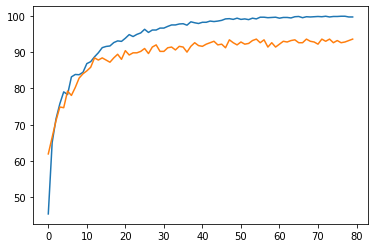

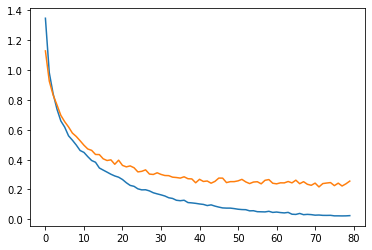

In [0]:
plt.figure()
plt.plot(train_accuracy_list)
plt.plot(test_accuracy_list)

plt.figure()
plt.plot(train_loss_list)
plt.plot(test_loss_list)

**Loading the best saved model:**

In [0]:
best_test_model1 = torch.load('/content/best_test_acc_model.pth')

**Pokemon Sample Inferences:**

In [5]:
!gdown https://drive.google.com/uc?id=1kiXeBqHdXzu-PYUbmgyrMnzNLc37JpmA

Downloading...
From: https://drive.google.com/uc?id=1kiXeBqHdXzu-PYUbmgyrMnzNLc37JpmA
To: /content/Pokemon_Samples.zip
100% 424k/424k [00:00<00:00, 62.6MB/s]


In [0]:
#Copying the Pokemon Sample Folder from the drive into the colab disk
!unzip /content/Pokemon_Samples.zip

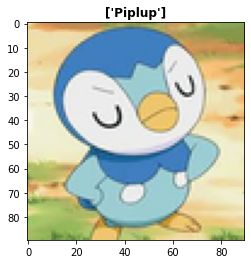

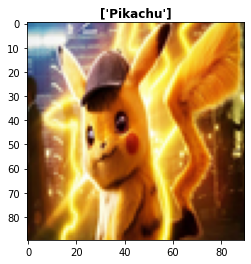

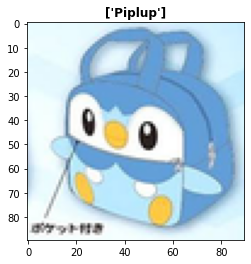

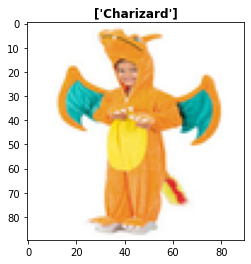

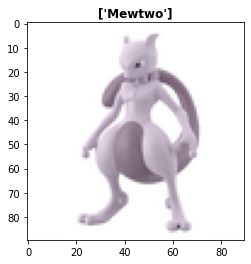

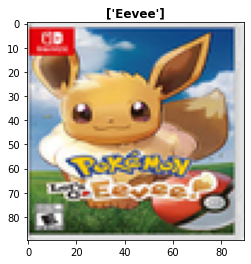

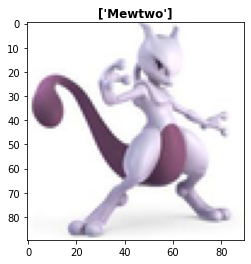

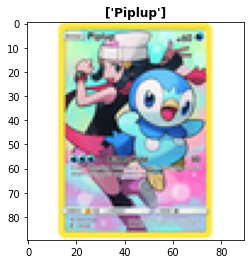

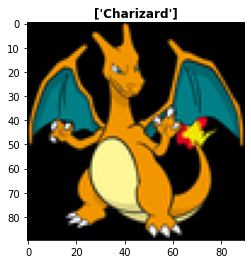

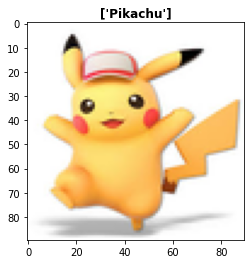

In [0]:
#Loop for loading each image and predict the out for each one
#The title of each image is the inference result of the model
pokemon_samples_path = '/content/content/Pokemon Samples'
for image_path in os.listdir(pokemon_samples_path):
  try:
    im = Image.open(os.path.join(pokemon_samples_path, image_path))
    im = im.convert("RGB")
    im = im.resize((90,90),Image.ANTIALIAS)
    loader = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    im_tensor = loader(im)
    im_tensor = im_tensor.view(1,3,90,90)
    im_tensor = im_tensor.cuda()  #assumes that you're using GPU
    output = best_test_model1.forward(im_tensor)
    #Get the class-to-index dictionary
    class_to_index_dict = train_loader.sampler.data_source.dataset.class_to_idx
    #Get the predicted class label
    prediction_label = output.argmax()
    plt.figure()
    #Print the title corresponding to the predicted label
    plt.title([k for k,v in class_to_index_dict.items() if v == prediction_label],fontweight="bold")
    plt.imshow(im)
  except IOError:
    pass